# Commuted Piano Synthesis Experiment

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## hammer-string interaction

100

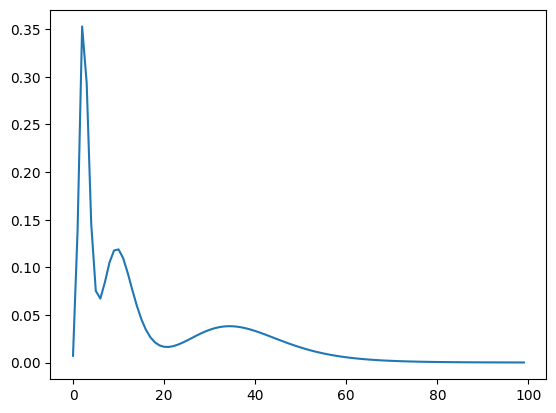

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from audio_utils import impulse

length = 100

x = np.linspace(-1, 10, 100)
strike1 = np.exp(-10 * (1 - np.pow(7, -0.75 - x)) ** 2)
strike1 /= sum(strike1)


x = np.linspace(-1.1, 2.5, 100)
strike2 = np.exp(-10 * (1 - np.pow(7, -0.75 - x)) ** 2)
strike2 /= sum(strike2)

x = np.linspace(-1.15, 0, 100)
strike3 = np.exp(-10 * (1 - np.pow(7, -0.75 - x)) ** 2)
strike3 /= sum(strike3)

strike = strike1 + strike2 + strike3
plt.plot(strike)

len(strike)
# mfcc_hash(strike)


## all-pass filter for dispersion

This might be backwards, but doing it the other way is causing instability. Check this out later.

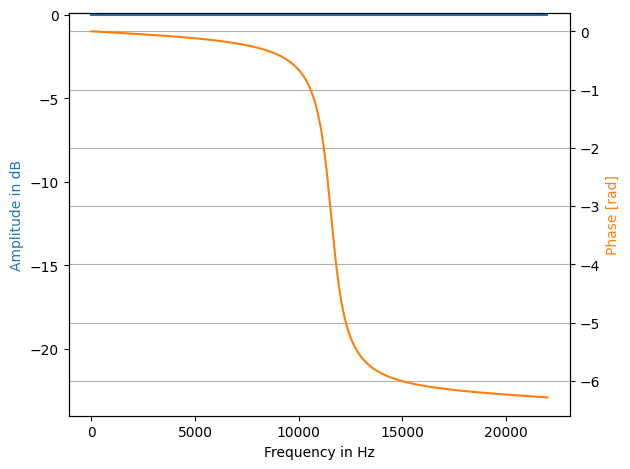

In [3]:
# See https://ccrma.stanford.edu/~jos/Piano/Piano.pdf
# for more information about the all-pass filter


from audio_utils import plot_freqz

ap_denom = np.array([7, 1.0, 6])


plot_freqz(ap_denom[::-1], ap_denom, 44100)


## a rich IR for the body

--2025-02-22 11:18:36--  https://oramics.github.io/sampled/IR/EMT140-Plate/samples/emt_140_dark_1.wav
Resolving oramics.github.io (oramics.github.io)... 2606:50c0:8000::153, 2606:50c0:8003::153, 2606:50c0:8001::153, ...
Connecting to oramics.github.io (oramics.github.io)|2606:50c0:8000::153|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



/var/folders/zk/5c2c39w140d2jm1q_p1lzdr00000gn/T/ipykernel_60178/4048299848.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, plate = wavfile.read("data/emt_140_dark_1.wav")


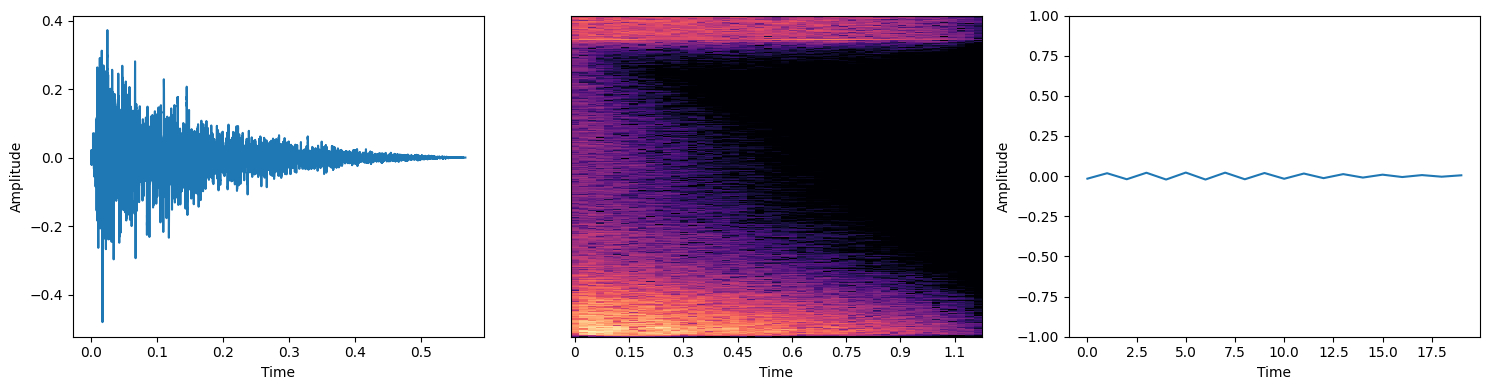

In [4]:
# download https://oramics.github.io/sampled/IR/EMT140-Plate/samples/emt_140_dark_1.wav to data/

! wget -c https://oramics.github.io/sampled/IR/EMT140-Plate/samples/emt_140_dark_1.wav -O data/emt_140_dark_1.wav

from scipy.io import wavfile

from audio_utils import play_audio

sr, plate = wavfile.read("data/emt_140_dark_1.wav")
plate = plate / (2**31)


def fade_out(x, seconds):
    output = np.zeros_like(x)

    fade = np.linspace(1, 0, seconds * sr)
    if len(fade) > len(x):
        fade = fade[-len(x) :]
    output[-len(fade) :] = x[-len(fade) :] * fade
    return output


plate_left = fade_out(plate[:25000, 0], 1)
plate_right = fade_out(plate[:25000, 1], 1)

play_audio(plate_left, auto_play=True)
assert len(plate_left) == 25000
assert sr == 48000

## the commuted synthesis model

This is all LTI's, so everything commutes. For simplicity, the hammer-string interaction is constant, but per https://ccrma.stanford.edu/~jos/pdf/svd95.pdf, the force diagram can be used as an easy source of nonlinearity by making it non-linearly dependent on the string velocity.

[0.52806561 1.05613121 0.52806561] [1.         0.90672491 0.20553751]
white_noise ['balanced-shiraz', 'broad-community', 'linear-mask']
white_noise


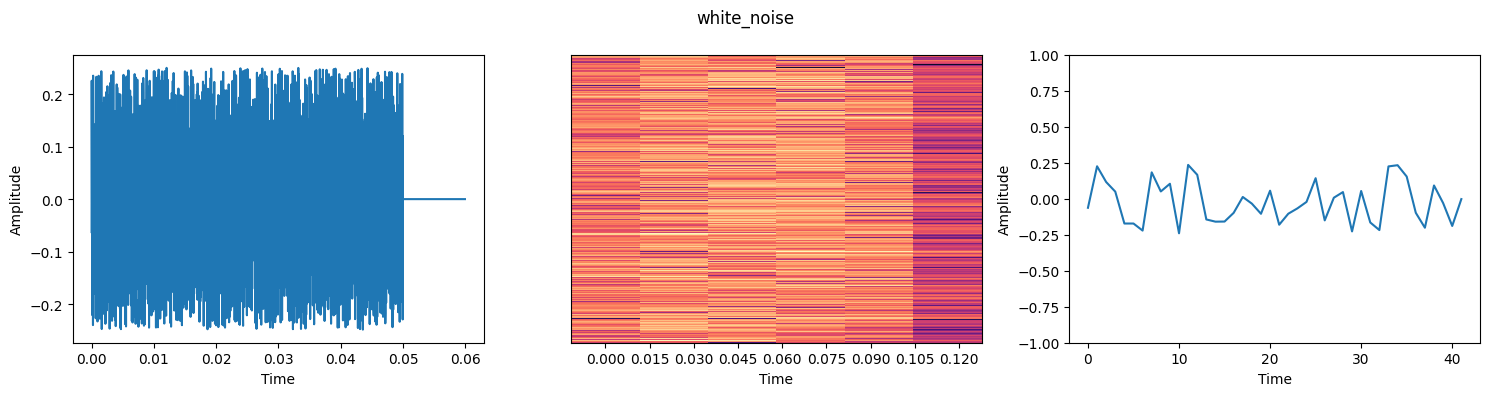

many filters ['watery-pressure', 'ambitious-photon', 'greasy-page']
many filters


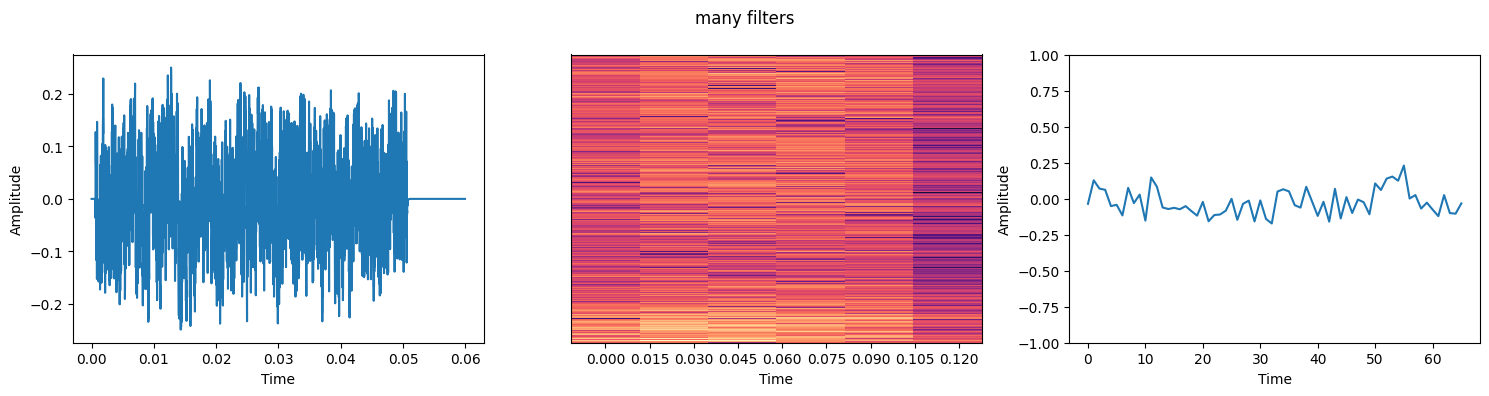

strike ['vibrato-patio', 'mashed-book', 'bipartite-sump']
strike


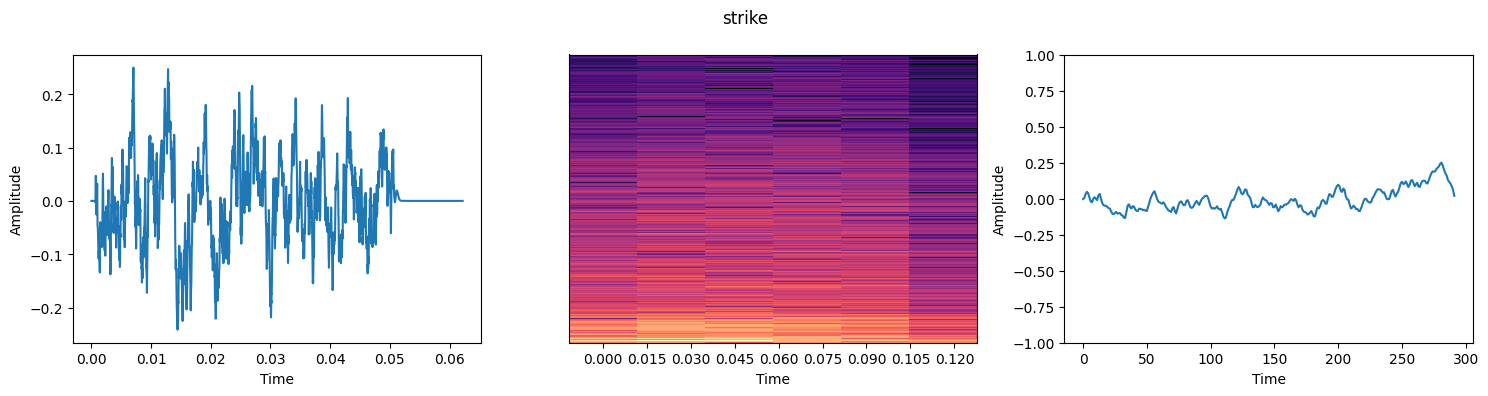

plate ['naive-line', 'descriptive-parameter', 'scared-contract']
plate


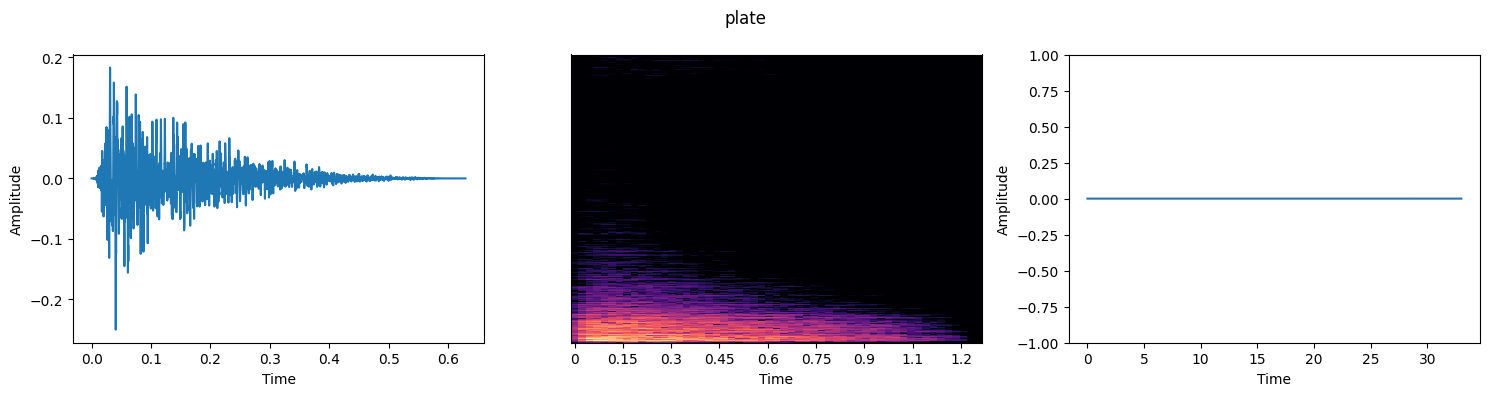

string ['upbeat-corona', 'frosty-draft', 'smoky-golf']
string


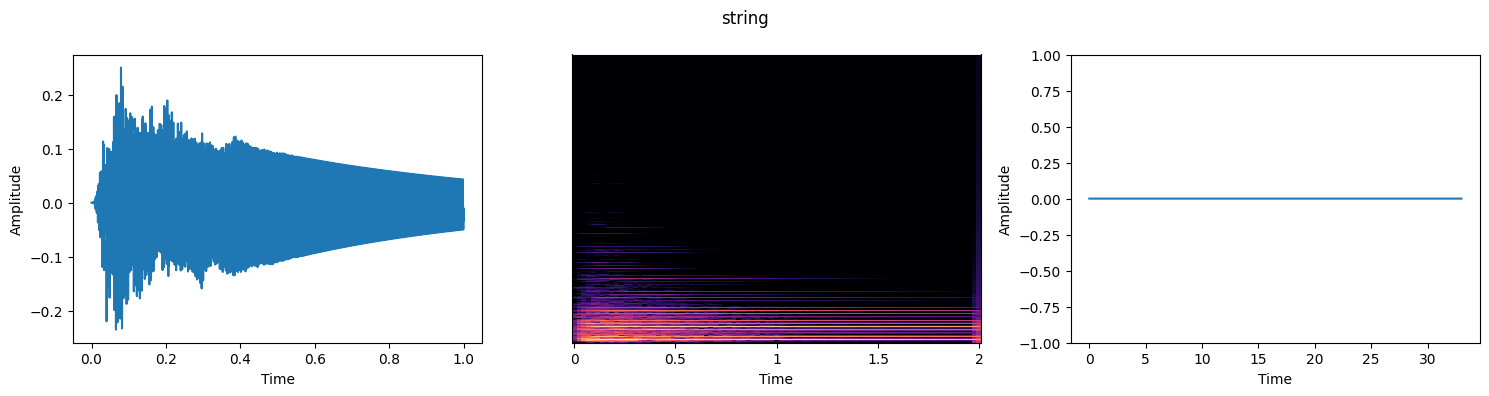

KeyboardInterrupt: 

In [5]:
import numpy as np
from joblib import Memory
from scipy.signal import convolve

from audio_utils import (
    add_silence,
    biquad_lpf_coeffs,
    comb,
    mfcc_hash,
    play_audio,
    string,
    white_noise,
)

memory = Memory("cache", verbose=0)


def mtof(m):
    return 440 * 2 ** ((m - 69) / 12)


def midi_to_piano_note(m, show_graphs=False, channel="L"):
    b, a = biquad_lpf_coeffs(17000, 0.5, 44100)
    print(b, a)
    ap_denom = np.array([7, 1, 6])

    res = impulse(0.01)

    res = convolve(res, white_noise(0.05))
    res /= np.max(np.abs(res))
    if show_graphs:
        print("white_noise", mfcc_hash(res)[:3])
        play_audio(0.25 * res, title="white_noise")

    for i in range(10):
        res = comb(res, int((5 + i) / 3), 0.95 - 0.03 * i, 0.10)
    res /= np.max(np.abs(res))
    if show_graphs:
        print("many filters", mfcc_hash(res)[:3])
        play_audio(0.25 * res, title="many filters")

    res = convolve(res, strike)
    res /= np.max(np.abs(res))
    if show_graphs:
        print("strike", mfcc_hash(res)[:3])
        play_audio(0.25 * res, title="strike")

    if channel == "L":
        res = convolve(plate_left, res)
    else:
        res = convolve(plate_right, res)
    res /= np.max(np.abs(res))
    if show_graphs:
        print("plate", mfcc_hash(res)[:3])
        play_audio(0.25 * res, title="plate")
    res = (
        0.5
        * string(
            add_silence(res, 5),
            int(44100.0 / mtof(m)),
            0.995,
            *b,
            *a,
            *ap_denom[::-1],
            *ap_denom,
        )
        + 0.2
        * string(
            add_silence(res, 5),
            int(44100.0 / mtof(m) / (0.9999)),
            (0.99),
            *b,
            *a,
            *ap_denom[::-1],
            *ap_denom,
        )
        + 0.1
        * string(
            add_silence(res, 5),
            int(44100.0 / mtof(m) / (10.0)),
            (0.999),
            *b,
            *a,
            *ap_denom[::-1],
            *ap_denom,
        )
    )
    res /= np.max(np.abs(res))
    if show_graphs:
        print("string", mfcc_hash(res)[:3])
        play_audio(0.25 * res, title="string")

    if show_graphs:
        print("final", mfcc_hash(res)[:3])
        play_audio(0.25 * res, auto_play=True, title="final")

    res /= np.max(np.abs(res))
    return res * 0.95  # avoid clipping


midi_to_piano_note(59, show_graphs=True)


midi_to_piano_note = memory.cache(midi_to_piano_note)


## write this out to wave files and render some piano piece

Something in the implementation is affecting the tuning. Look into this some more.

In [ ]:
# write as wav files
for m in range(12, 96):
    waves = np.array(
        [midi_to_piano_note(m, channel=channel) for channel in ["L", "R"]]
    ).T
    wavfile.write(f"data/piano_{m}.wav", 44100, (waves * 2**15).astype(np.int16))


In [ ]:
! wget -c "https://bitmidi.com/uploads/30381.mid" -O data/mozart_k545.mid


In [ ]:
from pydub import AudioSegment

(
    AudioSegment.from_wav(f"data/piano_{84}.wav")
    .apply_gain(-18)
    .get_sample_slice(np.random.randint(0, 30), int(1000 / 1000 * sr))
    .fade_out(100)
    .fade_in(30)
)


In [ ]:
from collections import defaultdict

from mido import MidiFile
from pydub import AudioSegment

mid = MidiFile("./data/mozart_k545.mid")
total_duration = 60 * 1000.0
output = AudioSegment.silent(total_duration)

tempo = 110  # bpm


def ticks_to_ms(ticks):
    tick_ms = (60000.0 / tempo) / mid.ticks_per_beat
    return ticks * tick_ms


sr = 44100
for track in mid.tracks:
    if "piano" not in track.name.lower() and len(mid.tracks) > 3:
        print(f"skipping {track.name}")
        continue
    print(f"Track {track.name}")

    current_pos = 0.0

    current_notes = defaultdict(dict)
    audio_segments = {}

    for msg in track:
        current_pos += ticks_to_ms(msg.time)
        if current_pos > total_duration:
            break

        if msg.type == "note_on" and msg.velocity > 0:
            current_notes[msg.channel][msg.note] = (current_pos, msg)

        if msg.type == "note_on" and msg.velocity == 0:
            if msg.note not in current_notes[msg.channel]:
                continue
            start_pos, start_msg = current_notes[msg.channel].pop(msg.note)
            print(
                f"rendering note {msg.note} at {current_pos} with velocity {start_msg.velocity}"
            )

            duration = current_pos - start_pos

            filename = f"data/piano_{msg.note}.wav"

            if filename not in audio_segments:
                audio_segments[msg.note] = AudioSegment.from_wav(filename)

            rendered = (
                audio_segments[msg.note]
                .apply_gain(-24)
                .apply_gain(20 * np.log10(start_msg.velocity / 127))
            )

            if msg.note < 84:
                rendered = rendered.get_sample_slice(
                    np.random.randint(0, 20),
                    max(int(duration / 1000.0 * 1.5 * sr), 700),
                )
            rendered = rendered.fade_out(100)

            output = output.overlay(rendered, start_pos)

output
